## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
len(tf.config.experimental.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7975903086850484904
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18394511243245515572
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4817616896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7504728849788204691
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3484811663922488048
physical_device_desc: "device: XLA_GPU device"
]


1

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization, Activation, Dropout
import keras.regularizers as  regularizers

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128],
              use_bn=True,
              drp_ratio=0.,
              l2_ratio=0.):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
EPOCHS = 20 

USE_BN = [True, False]
DRP_RATIO = [0., 0.4, 0.8]
L2_RATIO = [0., 1e-6, 1e-8]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
import keras.backend as K



for i ,(BN,DRP,L2) in enumerate(itertools.product(USE_BN,DRP_RATIO,L2_RATIO)):
    K.clear_session()
    

    
    model = build_mlp(input_shape=x_train.shape[1:],drp_ratio=DRP,l2_ratio=L2,use_bn=BN)

    
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy',
              metrics= ['accuracy'],
             optimizer = optimizer)
    
    
    model.fit(x_train,y_train,
              epochs =EPOCHS,
              batch_size = BATCH_SIZE,
             validation_data=(x_test,y_test),
              verbose= 1 ,
              shuffle= True
             )
    
    results['%s-%s-%s'%(BN,DRP,L2)]={
    'train_loss' :model.history.history['loss'] ,
    'valid_loss' : model.history.history['val_loss'] ,
   'train_acc' : model.history.history['accuracy'] ,
   'valid_acc' :model.history.history['val_accuracy'] }

Epoch 1/20
196/196 [==============================] - 1s 7ms/step - loss: 1.6245 - accuracy: 0.4250 - val_loss: 1.8056 - val_accuracy: 0.3520
Epoch 2/20
196/196 [==============================] - 1s 5ms/step - loss: 1.3777 - accuracy: 0.5095 - val_loss: 1.8109 - val_accuracy: 0.3761
Epoch 3/20
196/196 [==============================] - 1s 5ms/step - loss: 1.2505 - accuracy: 0.5552 - val_loss: 1.7378 - val_accuracy: 0.3942
Epoch 4/20
196/196 [==============================] - 1s 5ms/step - loss: 1.1583 - accuracy: 0.5886 - val_loss: 1.8906 - val_accuracy: 0.3613
Epoch 5/20
196/196 [==============================] - 1s 5ms/step - loss: 1.0737 - accuracy: 0.6214 - val_loss: 1.8514 - val_accuracy: 0.3703
Epoch 6/20
196/196 [==============================] - 1s 5ms/step - loss: 0.9976 - accuracy: 0.6468 - val_loss: 1.8864 - val_accuracy: 0.3693
Epoch 7/20
196/196 [==============================] - 1s 5ms/step - loss: 0.9184 - accuracy: 0.6763 - val_loss: 1.7732 - val_accuracy: 0.4068
Epoch 

196/196 [==============================] - 1s 5ms/step - loss: 0.2967 - accuracy: 0.8984 - val_loss: 2.3910 - val_accuracy: 0.4433
Epoch 19/20
196/196 [==============================] - 1s 5ms/step - loss: 0.2581 - accuracy: 0.9118 - val_loss: 2.4426 - val_accuracy: 0.4554
Epoch 20/20
196/196 [==============================] - 1s 5ms/step - loss: 0.2349 - accuracy: 0.9209 - val_loss: 2.9575 - val_accuracy: 0.4364
Epoch 1/20
196/196 [==============================] - 1s 6ms/step - loss: 1.9970 - accuracy: 0.2962 - val_loss: 1.8125 - val_accuracy: 0.3470
Epoch 2/20
196/196 [==============================] - 1s 5ms/step - loss: 1.7070 - accuracy: 0.3864 - val_loss: 1.7667 - val_accuracy: 0.3429
Epoch 3/20
196/196 [==============================] - 1s 5ms/step - loss: 1.6094 - accuracy: 0.4213 - val_loss: 1.6514 - val_accuracy: 0.4029
Epoch 4/20
196/196 [==============================] - 1s 5ms/step - loss: 1.5441 - accuracy: 0.4524 - val_loss: 1.7158 - val_accuracy: 0.3880
Epoch 5/20
196/

196/196 [==============================] - 1s 5ms/step - loss: 1.2587 - accuracy: 0.5536 - val_loss: 1.5350 - val_accuracy: 0.4418
Epoch 16/20
196/196 [==============================] - 1s 5ms/step - loss: 1.2374 - accuracy: 0.5606 - val_loss: 1.4916 - val_accuracy: 0.4590
Epoch 17/20
196/196 [==============================] - 1s 5ms/step - loss: 1.2203 - accuracy: 0.5670 - val_loss: 1.3826 - val_accuracy: 0.5070
Epoch 18/20
196/196 [==============================] - 1s 5ms/step - loss: 1.2010 - accuracy: 0.5745 - val_loss: 1.4299 - val_accuracy: 0.4909
Epoch 19/20
196/196 [==============================] - 1s 5ms/step - loss: 1.1870 - accuracy: 0.5774 - val_loss: 1.4029 - val_accuracy: 0.5037
Epoch 20/20
196/196 [==============================] - 1s 5ms/step - loss: 1.1743 - accuracy: 0.5831 - val_loss: 1.3979 - val_accuracy: 0.5013
Epoch 1/20
196/196 [==============================] - 1s 6ms/step - loss: 2.8745 - accuracy: 0.1263 - val_loss: 2.1272 - val_accuracy: 0.2320
Epoch 2/20
1

196/196 [==============================] - 1s 5ms/step - loss: 1.8678 - accuracy: 0.2965 - val_loss: 1.7559 - val_accuracy: 0.3538
Epoch 13/20
196/196 [==============================] - 1s 5ms/step - loss: 1.8615 - accuracy: 0.3005 - val_loss: 1.7587 - val_accuracy: 0.3389
Epoch 14/20
196/196 [==============================] - 1s 5ms/step - loss: 1.8450 - accuracy: 0.3097 - val_loss: 1.7311 - val_accuracy: 0.3709
Epoch 15/20
196/196 [==============================] - 1s 5ms/step - loss: 1.8371 - accuracy: 0.3153 - val_loss: 1.7379 - val_accuracy: 0.3680
Epoch 16/20
196/196 [==============================] - 1s 5ms/step - loss: 1.8251 - accuracy: 0.3200 - val_loss: 1.7004 - val_accuracy: 0.3859
Epoch 17/20
196/196 [==============================] - 1s 5ms/step - loss: 1.8139 - accuracy: 0.3260 - val_loss: 1.6908 - val_accuracy: 0.3948
Epoch 18/20
196/196 [==============================] - 1s 5ms/step - loss: 1.8068 - accuracy: 0.3314 - val_loss: 1.6817 - val_accuracy: 0.3897
Epoch 19/20

196/196 [==============================] - 1s 4ms/step - loss: 1.3770 - accuracy: 0.5096 - val_loss: 1.4961 - val_accuracy: 0.4676
Epoch 10/20
196/196 [==============================] - 1s 4ms/step - loss: 1.3533 - accuracy: 0.5175 - val_loss: 1.4553 - val_accuracy: 0.4873
Epoch 11/20
196/196 [==============================] - 1s 4ms/step - loss: 1.3265 - accuracy: 0.5282 - val_loss: 1.3941 - val_accuracy: 0.5012
Epoch 12/20
196/196 [==============================] - 1s 4ms/step - loss: 1.2987 - accuracy: 0.5365 - val_loss: 1.4033 - val_accuracy: 0.5011
Epoch 13/20
196/196 [==============================] - 1s 4ms/step - loss: 1.2838 - accuracy: 0.5426 - val_loss: 1.3945 - val_accuracy: 0.5085
Epoch 14/20
196/196 [==============================] - 1s 4ms/step - loss: 1.2569 - accuracy: 0.5511 - val_loss: 1.4122 - val_accuracy: 0.5021
Epoch 15/20
196/196 [==============================] - 1s 4ms/step - loss: 1.2413 - accuracy: 0.5575 - val_loss: 1.3592 - val_accuracy: 0.5253
Epoch 16/20

196/196 [==============================] - 1s 4ms/step - loss: 1.8930 - accuracy: 0.2952 - val_loss: 1.8441 - val_accuracy: 0.3403
Epoch 7/20
196/196 [==============================] - 1s 4ms/step - loss: 1.8907 - accuracy: 0.2975 - val_loss: 1.8282 - val_accuracy: 0.3564
Epoch 8/20
196/196 [==============================] - 1s 4ms/step - loss: 1.8838 - accuracy: 0.3018 - val_loss: 1.8224 - val_accuracy: 0.3641
Epoch 9/20
196/196 [==============================] - 1s 4ms/step - loss: 1.8784 - accuracy: 0.3019 - val_loss: 1.8158 - val_accuracy: 0.3704
Epoch 10/20
196/196 [==============================] - 1s 4ms/step - loss: 1.8566 - accuracy: 0.3136 - val_loss: 1.8131 - val_accuracy: 0.3609
Epoch 11/20
196/196 [==============================] - 1s 4ms/step - loss: 1.8505 - accuracy: 0.3139 - val_loss: 1.8057 - val_accuracy: 0.3566
Epoch 12/20
196/196 [==============================] - 1s 4ms/step - loss: 1.8501 - accuracy: 0.3208 - val_loss: 1.8163 - val_accuracy: 0.3445
Epoch 13/20
19

196/196 [==============================] - 1s 4ms/step - loss: 2.3029 - accuracy: 0.0971 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/20
196/196 [==============================] - 1s 4ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/20
196/196 [==============================] - 1s 4ms/step - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/20
196/196 [==============================] - 1s 4ms/step - loss: 2.3027 - accuracy: 0.0952 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/20
196/196 [==============================] - 1s 4ms/step - loss: 2.3027 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 8/20
196/196 [==============================] - 1s 4ms/step - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 9/20
196/196 [==============================] - 1s 4ms/step - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3026 - val_accuracy: 0.0999
Epoch 10/20
196/1

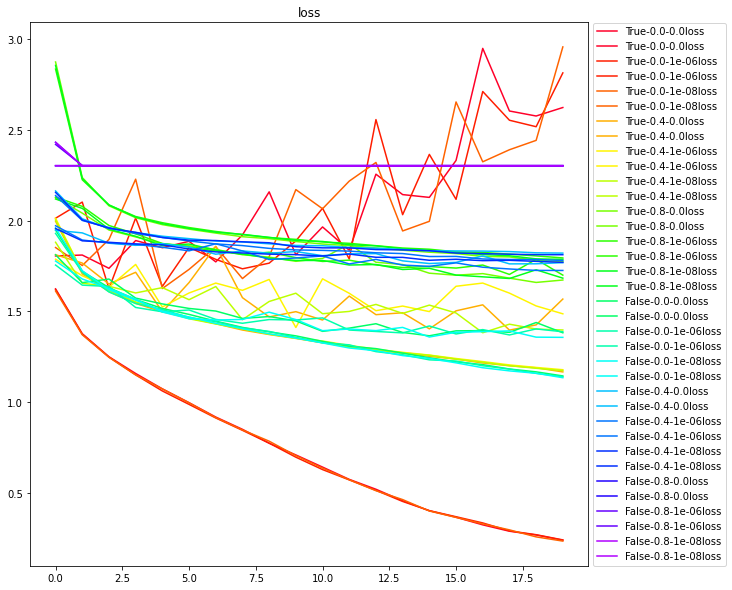

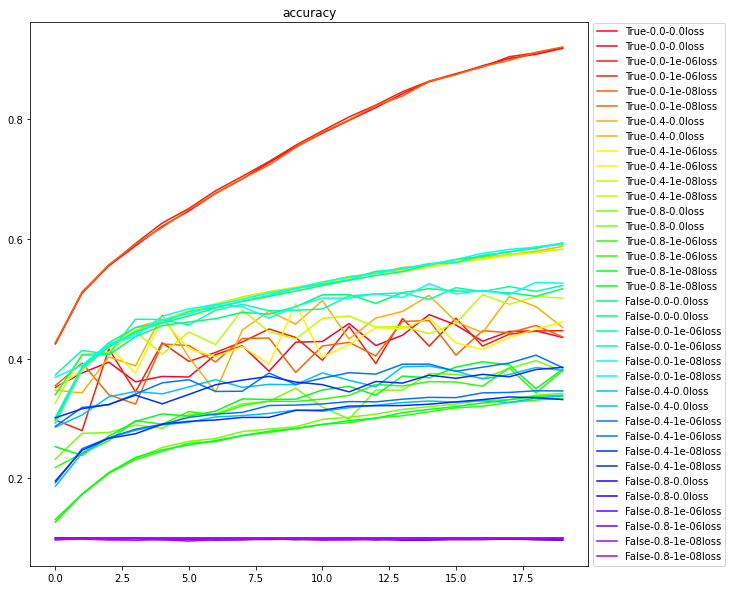

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = 20
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]


plt.figure(figsize =(10,10))
for i , cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'],
             '-',label=cond+'loss',color = color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'],
         '-',label=cond+'loss',color = color_bar[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('loss')
plt.show()

plt.figure(figsize =(10,10))
for i , cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'],
             '-',label=cond+'loss',color = color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'],
         '-',label=cond+'loss',color = color_bar[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('accuracy')
plt.show()